<a href="https://colab.research.google.com/github/sarahajbane/notebooks/blob/main/v001_MARIDA_EDA_AND_PREPROCESSING_jayash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio folium geopandas shapely plotly kagglehub #necessary imports, some not present in colab

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import rasterio
from rasterio.plot import show
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from shapely.geometry import Point
import glob
import cv2
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import kagglehub
import zipfile
import shutil
from datetime import datetime
import re

In [ ]:
# Set up the environment
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download the MARIDA dataset from the kaggle
print("Downloading MARIDA dataset from Kaggle...")
path = kagglehub.dataset_download("anangfath/marida-marine-debrish-dataset")
print(f"Path to dataset files: {path}")

100%|██████████| 1.08G/1.08G [00:16<00:00, 69.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anangfath/marida-marine-debrish-dataset/versions/1


In [ ]:
# Extract the dataset as it's in a zip file
if os.path.exists(f"{path}/marida.zip"):
    print("Extracting MARIDA dataset...")
    with zipfile.ZipFile(f"{path}/marida.zip", 'r') as zip_ref:
        zip_ref.extractall(path)
    print("Dataset extracted!")

# Defining our base directory
base_dir = path

# Create a directory for processed data
processed_dir = os.path.join(base_dir, "processed")
os.makedirs(processed_dir, exist_ok=True)

In [ ]:
# Define class names from the MARIDA repo
class_mapping = {
    1: 'Marine Debris',
    2: 'Dense Sargassum',
    3: 'Sparse Sargassum',
    4: 'Natural Organic Material',
    5: 'Ship',
    6: 'Clouds',
    7: 'Marine Water',
    8: 'Sediment-Laden Water',
    9: 'Foam',
    10: 'Turbid Water',
    11: 'Shallow Water',
    12: 'Waves',
    13: 'Cloud Shadows',
    14: 'Wakes',
    15: 'Mixed Water'
}

In [ ]:
# Define color mapping for visualization (used Deep seek for this)
color_mapping = {
    1: (255, 0, 0),      # Marine Debris - Red
    2: (0, 128, 0),      # Dense Sargassum - Green
    3: (144, 238, 144),  # Sparse Sargassum - Light Green
    4: (139, 69, 19),    # Natural Organic Material - Brown
    5: (128, 128, 128),  # Ship - Gray
    6: (255, 255, 255),  # Clouds - White
    7: (0, 0, 255),      # Marine Water - Blue
    8: (210, 180, 140),  # Sediment-Laden Water - Tan
    9: (255, 255, 224),  # Foam - Light Yellow
    10: (64, 224, 208),  # Turbid Water - Turquoise
    11: (176, 224, 230), # Shallow Water - Powder Blue
    12: (0, 191, 255),   # Waves - Deep Sky Blue
    13: (105, 105, 105), # Cloud Shadows - Dim Gray
    14: (220, 220, 220), # Wakes - Gainsboro
    15: (70, 130, 180)   # Mixed Water - Steel Blue
}

In [ ]:
def analyze_dataset_structure():
    """Analyze the dataset structure and print basic statistics"""
    # Path to patches directory
    patches_dir = os.path.join(base_dir, "patches")

    if not os.path.exists(patches_dir):
        print(f"Error: Patches directory not found at {patches_dir}")
        return None

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    print(f"Total number of S2 date-tile directories: {len(s2_dirs)}")

    # Count different types of files
    image_count = 0
    mask_count = 0
    conf_count = 0

    # Extract information from filenames
    tiles = []
    dates = []
    locations = []

    # Extract date and tile information
    for s2_dir in tqdm(s2_dirs, desc="Analyzing directories"):
        dir_path = os.path.join(patches_dir, s2_dir)
        files = os.listdir(dir_path)

        # Count file types
        images = [f for f in files if not f.endswith('_cl.tif') and not f.endswith('_conf.tif') and f.endswith('.tif')]
        masks = [f for f in files if f.endswith('_cl.tif')]
        confs = [f for f in files if f.endswith('_conf.tif')]

        image_count += len(images)
        mask_count += len(masks)
        conf_count += len(confs)

        """ Extract date and tile information - FIXED PATTERN MATCHING
            The directory structure might be different than expected
            Handle the case when dates list might be empty """
        try:
            # Try different pattern formats that might exist in your data
            # Original pattern: r'S2_(\d{8})_(\w+)'
            # Modified patterns:
            match = re.match(r'S2_(\d{8})_(\w+)', s2_dir)  # Original pattern
            if not match:
                match = re.match(r'(\d{8})_(\w+)', s2_dir)  # Try without 'S2_'
            if not match:
                match = re.match(r'S2_(\d{8})', s2_dir)  # Try without tile information
            if not match:
                match = re.match(r'(\d{8})', s2_dir)  # Try only date

            if match:
                date_str = match.group(1)  # Always get the first group (date)
                date = datetime.strptime(date_str, '%Y%m%d')
                dates.append(date)

                if len(match.groups()) > 1:
                    tile = match.group(2)  # Get tile information if available
                    tiles.append(tile)

        except (ValueError, IndexError) as e:
            print(f"Warning: Could not extract date or tile from '{s2_dir}': {e}")

    # Check if dates list is still empty after trying different patterns
    if not dates:
        print("Warning: Could not extract dates from directory names after trying different patterns")
        # Print directory names for debugging
        print(f"Sample directory names: {s2_dirs[:5] if len(s2_dirs) >= 5 else s2_dirs}")
        print("Date range: Unknown")
    else:
        print(f"Date range: {min(dates).strftime('%Y-%m-%d')} to {max(dates).strftime('%Y-%m-%d')}")


    print(f"Total number of image patches: {image_count}")
    print(f"Total number of classification masks: {mask_count}")
    print(f"Total number of confidence level masks: {conf_count}")

    # Analyze train/val/test splits
    splits_dir = os.path.join(base_dir, "splits")
    if os.path.exists(splits_dir):
        split_files = [f for f in os.listdir(splits_dir) if f.endswith('.txt')]
        print("\nTrain/Val/Test splits:")
        for split_file in split_files:
            with open(os.path.join(splits_dir, split_file), 'r') as f:
                samples = f.readlines()
            print(f"  {split_file}: {len(samples)} samples")

    # Analyze labels mapping for multi-label classification
    labels_mapping_file = os.path.join(base_dir, "labels_mapping.txt")
    if os.path.exists(labels_mapping_file):
        with open(labels_mapping_file, 'r') as f:
            label_lines = f.readlines()
        print(f"\nMulti-label classification mapping: {len(label_lines)} entries")

    return {
        'image_count': image_count,
        'mask_count': mask_count,
        'conf_count': conf_count,
        'date_range': (min(dates), max(dates)) if dates else (None, None) # Handle empty dates
    }

dataset_stats = analyze_dataset_structure()

In [ ]:
# Class Distribution Analysis

def analyze_class_distribution(sample_size=50):
    """Analyze the distribution of classes in the dataset"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize class counts
    class_counts = {i: 0 for i in range(1, 16)}
    total_pixels = 0

    for s2_dir in tqdm(s2_dirs_sample, desc="Analyzing class distribution"):
        dir_path = os.path.join(patches_dir, s2_dir)
        mask_files = [f for f in os.listdir(dir_path) if f.endswith('_cl.tif')]

        for mask_file in mask_files:
            mask_path = os.path.join(dir_path, mask_file)
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)

                # Count class pixels
                for class_id in range(1, 16):
                    class_counts[class_id] += np.sum(mask_data == class_id)

                total_pixels += mask_data.size

    # Calculate percentages
    class_percentages = {class_id: count / total_pixels * 100
                         for class_id, count in class_counts.items()}

    # Print results
    print(f"Class distribution (based on {sample_size} random samples):")
    for class_id, percentage in sorted(class_percentages.items(), key=lambda x: x[1], reverse=True):
        print(f"  {class_id}: {class_mapping[class_id]} - {percentage:.2f}%")

    # Plot class distribution
    plt.figure(figsize=(14, 8))
    plt.bar(
        [class_mapping[i] for i in range(1, 16)],
        [class_percentages[i] for i in range(1, 16)]
    )
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of Pixels")
    plt.title("Class Distribution in MARIDA Dataset")
    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "class_distribution.png"))
    plt.show()

    # Calculate debris vs non-debris
    debris_percentage = class_percentages[1]
    non_debris_percentage = sum([p for i, p in class_percentages.items() if i != 1])

    print(f"\nDebris vs. Non-debris:")
    print(f"  Marine Debris: {debris_percentage:.2f}%")
    print(f"  Non-debris: {non_debris_percentage:.2f}%")

    # Plot debris vs non-debris
    plt.figure(figsize=(10, 6))
    plt.pie([debris_percentage, non_debris_percentage],
            labels=['Marine Debris', 'Non-debris'],
            autopct='%1.1f%%',
            colors=['#FF5733', '#3374FF'])
    plt.title("Marine Debris vs. Non-debris Distribution")
    plt.savefig(os.path.join(processed_dir, "debris_vs_non_debris.png"))
    plt.show()

    return class_percentages

class_distribution = analyze_class_distribution()

In [ ]:
# Spectral Analysis

def extract_spectral_signatures(sample_size=20):
    """Extract spectral signatures for different classes"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize spectral signatures dictionary
    spectral_signatures = {class_id: [] for class_id in range(1, 16)}

    for s2_dir in tqdm(s2_dirs_sample, desc="Extracting spectral signatures"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image-mask pairs
        image_files = [f for f in os.listdir(dir_path) if not f.endswith('_cl.tif') and not f.endswith('_conf.tif') and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)
            mask_file = image_file.replace('.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open image and mask
            with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
                img_data = img_src.read()
                mask_data = mask_src.read(1)

                # For each class, extract spectral signatures
                for class_id in range(1, 16):
                    class_pixels = np.where(mask_data == class_id)

                    if len(class_pixels[0]) > 0:
                        # Sample up to 100 pixels per class per image
                        sample_indices = np.random.choice(len(class_pixels[0]),
                                                          min(100, len(class_pixels[0])),
                                                          replace=False)

                        for idx in sample_indices:
                            pixel_y, pixel_x = class_pixels[0][idx], class_pixels[1][idx]
                            spectral_signature = img_data[:, pixel_y, pixel_x]
                            spectral_signatures[class_id].append(spectral_signature)

    # Calculate mean spectral signatures
    mean_signatures = {}
    for class_id, signatures in spectral_signatures.items():
        if signatures:
            mean_signatures[class_id] = np.mean(signatures, axis=0)

    # Plot mean spectral signatures
    plt.figure(figsize=(14, 8))

    for class_id, signature in mean_signatures.items():
        plt.plot(signature, label=f"{class_id}: {class_mapping[class_id]}")

    plt.xlabel("Sentinel-2 Band")
    plt.ylabel("Reflectance")
    plt.title("Mean Spectral Signatures by Class")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(processed_dir, "spectral_signatures.png"))
    plt.show()

    # Focus on debris vs other classes
    plt.figure(figsize=(14, 8))

    # Plot debris
    if 1 in mean_signatures:
        plt.plot(mean_signatures[1], 'r-', linewidth=3, label=f"1: {class_mapping[1]}")

    for class_id, signature in mean_signatures.items():
        plt.plot(signature, label=f"{class_id}: {class_mapping[class_id]}")

    plt.xlabel("Sentinel-2 Band")
    plt.ylabel("Reflectance")
    plt.title("Mean Spectral Signatures by Class")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(processed_dir, "spectral_signatures.png"))
    plt.show()

    # Focus on debris vs other classes
    plt.figure(figsize=(14, 8))

    # Plot debris
    if 1 in mean_signatures:
        plt.plot(mean_signatures[1], 'r-', linewidth=3, label=f"1: {class_mapping[1]}")

    # Plot other classes
    for class_id, signature in mean_signatures.items():
        if class_id != 1:  # Skip debris
            plt.plot(signature, '--', alpha=0.7, label=f"{class_id}: {class_mapping[class_id]}")

    plt.xlabel("Sentinel-2 Band")
    plt.ylabel("Reflectance")
    plt.title("Spectral Signature: Marine Debris vs. Other Classes")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(processed_dir, "debris_vs_others_spectral.png"))
    plt.show()

    return mean_signatures

# Execute spectral analysis
mean_spectral_signatures = extract_spectral_signatures()

In [ ]:
# Band Correlation Analysis

def analyze_band_correlations(sample_size=20):
    """Analyze correlations between spectral bands"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize band data collection
    band_data = []

    for s2_dir in tqdm(s2_dirs_sample, desc="Collecting band data"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image files
        image_files = [f for f in os.listdir(dir_path)
                     if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                     and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)

            with rasterio.open(image_path) as src:
                img_data = src.read()
                num_bands = img_data.shape[0]

                # Flatten spatial dimensions, keep band dimension
                img_flat = img_data.reshape(num_bands, -1)

                # Sample pixels (to avoid memory issues)
                num_pixels = img_flat.shape[1]
                sample_indices = np.random.choice(num_pixels, min(1000, num_pixels), replace=False)
                img_sample = img_flat[:, sample_indices]

                # Transpose to have bands as columns
                band_data.append(img_sample.T)

    # Combine all samples
    band_data_combined = np.vstack(band_data)

    # Create DataFrame for correlation analysis
    band_df = pd.DataFrame(band_data_combined,
                          columns=[f"Band_{i+1}" for i in range(band_data_combined.shape[1])])

    # Calculate correlation matrix
    corr_matrix = band_df.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Band Correlation Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "band_correlation.png"))
    plt.show()

    # Identify highly correlated bands
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))

    if high_corr_pairs:
        print("Highly correlated band pairs (|r| > 0.8):")
        for band1, band2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {band1} and {band2}: r = {corr:.3f}")
    else:
        print("No highly correlated band pairs found (|r| > 0.8).")

    return corr_matrix

# Execute band correlation analysis
band_correlations = analyze_band_correlations()

In [ ]:
# Spectral Indices Calculation

def calculate_and_visualize_indices(sample_size=10):
    """Calculate and visualize spectral indices for marine debris detection"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    """ Define band indices for common Sentinel-2 bands
        Assuming the spectral bands are in this order:
        B2 (Blue), B3 (Green), B4 (Red), B5 (Red Edge 1), B6 (Red Edge 2),
        B7 (Red Edge 3), B8 (NIR), B8A (NIR narrow), B11 (SWIR 1), B12 (SWIR 2)"""
    blue_idx = 0    # B2
    green_idx = 1   # B3
    red_idx = 2     # B4
    nir_idx = 6     # B8
    swir1_idx = 8   # B11
    swir2_idx = 9   # B12

    for s2_dir in tqdm(s2_dirs_sample, desc="Processing spectral indices"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image-mask pairs
        image_files = [f for f in os.listdir(dir_path)
                     if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                     and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)
            mask_file = image_file.replace('.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open image and mask
            with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
                img_data = img_src.read()
                mask_data = mask_src.read(1)

                # Get metadata for saving indices
                meta = img_src.meta.copy()
                meta.update(count=1)

                # Extract specific bands
                try:
                    blue = img_data[blue_idx]
                    green = img_data[green_idx]
                    red = img_data[red_idx]
                    nir = img_data[nir_idx]
                    swir1 = img_data[swir1_idx]
                    swir2 = img_data[swir2_idx]
                except IndexError:
                    print(f"  Warning: Not all required bands are available in {image_file}")
                    continue

                # Calculate spectral indices with epsilon to avoid division by zero
                eps = 1e-8

                # NDVI - Normalized Difference Vegetation Index
                ndvi = (nir - red) / (nir + red + eps)

                # NDWI - Normalized Difference Water Index (McFeeters)
                ndwi = (green - nir) / (green + nir + eps)

                # MNDWI - Modified Normalized Difference Water Index
                mndwi = (green - swir1) / (green + swir1 + eps)

                # AWEI - Automated Water Extraction Index
                awei = 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)

                # FDI - Floating Debris Index
                fdi = nir - (red + (nir - red) * ((swir1 - red) / (nir - red + eps)))

                # Calculate index for detecting plastic specifically
                # PPI - Plastic Presence Index (Custom index)
                ppi = (swir1 - nir) / (swir1 + nir + eps)

                # Save directories for indices
                indices_dir = os.path.join(processed_dir, "indices", s2_dir)
                os.makedirs(indices_dir, exist_ok=True)

                # Display RGB and indices for a sample image
                if np.random.random() < 0.3:  # Only plot ~30% of processed images
                    fig, axs = plt.subplots(2, 4, figsize=(18, 10))

                    # RGB composite
                    rgb = np.stack([red, green, blue], axis=0)
                    rgb = np.transpose(rgb, (1, 2, 0))
                    # Normalize for display
                    rgb_norm = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb) + eps)

                    axs[0, 0].imshow(rgb_norm)
                    axs[0, 0].set_title("RGB Composite")

                    # Create a mask for marine debris
                    debris_mask = np.zeros_like(mask_data)
                    debris_mask[mask_data == 1] = 1

                    # Display mask
                    axs[0, 1].imshow(debris_mask, cmap='binary_r')
                    axs[0, 1].set_title("Marine Debris Mask")

                    # Display indices
                    axs[0, 2].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
                    axs[0, 2].set_title("NDVI")

                    axs[0, 3].imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
                    axs[0, 3].set_title("NDWI")

                    axs[1, 0].imshow(mndwi, cmap='Blues', vmin=-1, vmax=1)
                    axs[1, 0].set_title("MNDWI")

                    axs[1, 1].imshow(awei, cmap='viridis')
                    axs[1, 1].set_title("AWEI")

                    axs[1, 2].imshow(fdi, cmap='plasma')
                    axs[1, 2].set_title("FDI")

                    axs[1, 3].imshow(ppi, cmap='RdBu', vmin=-1, vmax=1)
                    axs[1, 3].set_title("PPI (Plastic)")

                    plt.tight_layout()
                    plt.savefig(os.path.join(indices_dir, f"{image_file.replace('.tif', '_indices.png')}"))
                    plt.show()

                    # Save indices as GeoTIFF
                    indices_stack = np.stack([ndvi, ndwi, mndwi, awei, fdi, ppi])
                    meta.update(count=6)

                    with rasterio.open(
                        os.path.join(indices_dir, f"{image_file.replace('.tif', '_indices.tif')}"),
                        'w',
                        **meta
                    ) as dst:
                        dst.write(indices_stack)

    print("Spectral indices calculated and saved.")

# Execute spectral indices calculation
calculate_and_visualize_indices()

In [ ]:
# Confidence Level Analysis

def analyze_confidence_levels(sample_size=30):
    """Analyze annotator confidence levels for different classes"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize confidence data
    class_confidence = {class_id: [] for class_id in range(1, 16)}

    for s2_dir in tqdm(s2_dirs_sample, desc="Analyzing confidence levels"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find confidence mask files
        conf_files = [f for f in os.listdir(dir_path) if f.endswith('_conf.tif')]

        for conf_file in conf_files:
            conf_path = os.path.join(dir_path, conf_file)
            mask_file = conf_file.replace('_conf.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open confidence and class masks
            with rasterio.open(conf_path) as conf_src, rasterio.open(mask_path) as mask_src:
                conf_data = conf_src.read(1)
                mask_data = mask_src.read(1)

                # For each class, extract confidence levels
                for class_id in range(1, 16):
                    class_pixels = np.where(mask_data == class_id)

                    if len(class_pixels[0]) > 0:
                        # Get confidence values for this class
                        class_conf = conf_data[class_pixels]
                        class_confidence[class_id].extend(class_conf.flatten())

    # Calculate confidence statistics
    confidence_stats = {}
    for class_id, conf_values in class_confidence.items():
        if conf_values:
            confidence_stats[class_id] = {
                'mean': np.mean(conf_values),
                'median': np.median(conf_values),
                'std': np.std(conf_values),
                'min': np.min(conf_values),
                'max': np.max(conf_values)
            }

    # Plot confidence distributions
    plt.figure(figsize=(14, 8))

    # Only include classes with data
    valid_classes = [class_id for class_id, values in class_confidence.items() if values]

    # Create violin plot
    violin_data = [class_confidence[class_id] for class_id in valid_classes]
    violin_labels = [class_mapping[class_id] for class_id in valid_classes]

    plt.violinplot(violin_data, showmedians=True)
    plt.xticks(range(1, len(valid_classes) + 1), violin_labels, rotation=90)
    plt.ylabel("Confidence Level")
    plt.title("Distribution of Annotator Confidence by Class")
    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "confidence_distribution.png"))
    plt.show()

    # Print results
    print("Annotator confidence statistics by class:")
    for class_id, stats in sorted(confidence_stats.items(), key=lambda x: x[1]['mean'], reverse=True):
        print(f"  {class_id}: {class_mapping[class_id]}")
        print(f"    Mean: {stats['mean']:.2f}")
        print(f"    Median: {stats['median']:.2f}")
        print(f"    Std Dev: {stats['std']:.2f}")
        print(f"    Range: {stats['min']:.2f} - {stats['max']:.2f}")

    # Focus on marine debris confidence
    if 1 in confidence_stats:
        print("\nMarine Debris confidence statistics:")
        stats = confidence_stats[1]
        print(f"  Mean: {stats['mean']:.2f}")
        print(f"  Median: {stats['median']:.2f}")
        print(f"  Std Dev: {stats['std']:.2f}")
        print(f"  Range: {stats['min']:.2f} - {stats['max']:.2f}")

    return confidence_stats

# Execute confidence level analysis
confidence_statistics = analyze_confidence_levels()

In [ ]:
# Temporal Analysis

def analyze_temporal_patterns():
    """Analyze temporal patterns in debris occurrence"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Extract date information and debris presence
    dates = []
    debris_presence = []

    for s2_dir in tqdm(s2_dirs, desc="Extracting temporal data"):
        # Extract date from directory name using a more flexible pattern
        try:
            # Try different pattern formats that might exist in your data
            match = re.search(r'S2_(\d{1,2}-\d{1,2}-\d{2})_(\w+)', s2_dir)  # dd-mm-yy format
            if not match:
                match = re.search(r'S2_(\d{1,2}-\d{1,2}-\d{4})_(\w+)', s2_dir)  # dd-mm-yyyy format
            if not match:
                match = re.search(r'S2_(\d{8})_(\w+)', s2_dir)  # yyyymmdd format (original)

            if match:
                date_str = match.group(1)

                # Handle different date formats
                try:
                    date = datetime.strptime(date_str, '%d-%m-%y')
                except ValueError:
                    try:
                        date = datetime.strptime(date_str, '%d-%m-%Y')
                    except ValueError:
                        date = datetime.strptime(date_str, '%Y%m%d')

                dates.append(date)

            # Check for debris presence in any image within the directory
            dir_path = os.path.join(patches_dir, s2_dir)
            mask_files = [f for f in os.listdir(dir_path) if f.endswith('_cl.tif')]

            has_debris = False
            for mask_file in mask_files:
                mask_path = os.path.join(dir_path, mask_file)
                with rasterio.open(mask_path) as src:
                    mask_data = src.read(1)
                    if np.any(mask_data == 1):  # Check for marine debris (class 1)
                        has_debris = True
                        break

            debris_presence.append(has_debris)

        except AttributeError:
            print(f"Warning: Could not extract date from directory name: {s2_dir}")

    # Create DataFrame for analysis
    temporal_df = pd.DataFrame({'date': dates, 'debris_present': debris_presence})

    # Group by date and count debris occurrences
    debris_counts = temporal_df.groupby('date')['debris_present'].sum().reset_index()

    # Plot temporal patterns
    plt.figure(figsize=(14, 6))
    plt.plot(debris_counts['date'], debris_counts['debris_present'], marker='o')
    plt.title('Temporal Pattern of Marine Debris Detection')
    plt.xlabel('Date')
    plt.ylabel('Number of Locations with Debris')
    plt.grid(True)
    plt.savefig(os.path.join(processed_dir, "temporal_patterns.png"))
    plt.show()

    return debris_counts

# Execute temporal analysis
temporal_patterns = analyze_temporal_patterns()

In [ ]:
# Object Size and Shape Analysis

def analyze_object_properties(sample_size=50):
    """Analyze the size and shape of debris objects"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize lists to store object properties
    areas = []
    perimeters = []

    for s2_dir in tqdm(s2_dirs_sample, desc="Analyzing object properties"):
        dir_path = os.path.join(patches_dir, s2_dir)
        mask_files = [f for f in os.listdir(dir_path) if f.endswith('_cl.tif')]

        for mask_file in mask_files:
            mask_path = os.path.join(dir_path, mask_file)
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)

                # Find debris objects (class 1)
                debris_objects = mask_data == 1

                # Label connected components
                from skimage.measure import label, regionprops
                labeled_objects = label(debris_objects)

                # Calculate properties for each object
                for region in regionprops(labeled_objects):
                    areas.append(region.area)
                    perimeters.append(region.perimeter)

    # Plot distributions
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Area distribution
    axs[0].hist(areas, bins=50, color='green', edgecolor='black')
    axs[0].set_title('Distribution of Debris Object Areas')
    axs[0].set_xlabel('Area (pixels)')
    axs[0].set_ylabel('Frequency')

    # Perimeter distribution
    axs[1].hist(perimeters, bins=50, color='blue', edgecolor='black')
    axs[1].set_title('Distribution of Debris Object Perimeters')
    axs[1].set_xlabel('Perimeter (pixels)')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "object_properties.png"))
    plt.show()

    return {'areas': areas, 'perimeters': perimeters}

# Execute object properties analysis
object_properties = analyze_object_properties()

In [ ]:
# Data Visualization with Plastic Debris Highlighting

def visualize_data_with_plastic_highlight(sample_size=10):
    """Visualize sample data and highlight plastic debris"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    for s2_dir in tqdm(s2_dirs_sample, desc="Visualizing data"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image-mask pairs
        image_files = [f for f in os.listdir(dir_path)
                       if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                       and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)
            mask_file = image_file.replace('.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open image and mask
            with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
                img_data = img_src.read()
                mask_data = mask_src.read(1)

                # Create RGB composite for visualization
                rgb = np.stack([img_data[2], img_data[1], img_data[0]], axis=0)  # Assuming R, G, B order
                rgb = np.transpose(rgb, (1, 2, 0))
                rgb_norm = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))  # Normalize for display

                # Create a mask for plastic debris (class 1)
                plastic_mask = np.zeros_like(mask_data)
                plastic_mask[mask_data == 1] = 1

                # Highlight plastic debris on the image
                highlighted_image = rgb_norm.copy()
                highlighted_image[plastic_mask == 1] = [1, 0, 0]  # Highlight in red

                # Display the image and highlighted image
                fig, axs = plt.subplots(1, 2, figsize=(14, 7))
                axs[0].imshow(rgb_norm)
                axs[0].set_title("Original Image")
                axs[1].imshow(highlighted_image)
                axs[1].set_title("Plastic Debris Highlighted")
                plt.tight_layout()
                plt.show()

visualize_data_with_plastic_highlight(sample_size=10)

In [ ]:
# Custom Indices for Plastic Debris

def develop_plastic_indices(sample_size=20):
    """Develop and evaluate custom indices specifically for plastic debris detection"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Define band indices for common Sentinel-2 bands
    blue_idx = 0    # B2
    green_idx = 1   # B3
    red_idx = 2     # B4
    rededge1_idx = 3  # B5
    rededge2_idx = 4  # B6
    rededge3_idx = 5  # B7
    nir_idx = 6     # B8
    nir2_idx = 7    # B8A
    swir1_idx = 8   # B11
    swir2_idx = 9   # B12

    # Initialize statistics for each index
    index_stats = {
        'PFI': {'debris': [], 'non_debris': []},  # Plastic Float Index
        'NDPI': {'debris': [], 'non_debris': []}, # Normalized Difference Plastic Index
        'PDRI': {'debris': [], 'non_debris': []}, # Plastic Debris Ratio Index
        'PFDI': {'debris': [], 'non_debris': []}  # Plastic Floating Debris Index
    }

    for s2_dir in tqdm(s2_dirs_sample, desc="Calculating plastic indices"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image-mask pairs
        image_files = [f for f in os.listdir(dir_path)
                     if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                     and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)
            mask_file = image_file.replace('.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open image and mask
            with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
                img_data = img_src.read()
                mask_data = mask_src.read(1)

                # Extract debris mask
                debris_mask = mask_data == 1
                non_debris_mask = (mask_data > 1) & (mask_data < 16)  # All other valid classes

                # Skip if no debris or non-debris pixels
                if not np.any(debris_mask) or not np.any(non_debris_mask):
                    continue

                # Extract bands
                try:
                    blue = img_data[blue_idx]
                    green = img_data[green_idx]
                    red = img_data[red_idx]
                    rededge1 = img_data[rededge1_idx]
                    nir = img_data[nir_idx]
                    swir1 = img_data[swir1_idx]
                    swir2 = img_data[swir2_idx]
                except IndexError:
                    continue

                # Add small epsilon to avoid division by zero
                eps = 1e-8

                # Calculate custom plastic indices

                # PFI - Plastic Float Index (highlighting floating materials with plastic spectral characteristics)
                pfi = (swir1 - nir) / (swir1 + nir + eps) * (rededge1 / (blue + eps))

                # NDPI - Normalized Difference Plastic Index (targeting specific plastic reflectance features)
                ndpi = (swir1 - red) / (swir1 + red + eps)

                # PDRI - Plastic Debris Ratio Index (ratio-based approach using key bands)
                pdri = (swir1 / (nir + eps)) * (blue / (green + eps))

                # PFDI - Plastic Floating Debris Index (complex index targeting floating plastic)
                pfdi = (swir1 - blue) / (swir1 + blue + eps) * (nir / (red + eps)) - (swir2 / (swir1 + eps))

                # Collect statistics for each index
                indices = {'PFI': pfi, 'NDPI': ndpi, 'PDRI': pdri, 'PFDI': pfdi}

                for index_name, index_values in indices.items():
                    # Sample values (to avoid memory issues with large images)
                    debris_pixels = index_values[debris_mask]
                    if len(debris_pixels) > 1000:
                        debris_pixels = np.random.choice(debris_pixels, 1000, replace=False)

                    non_debris_pixels = index_values[non_debris_mask]
                    if len(non_debris_pixels) > 1000:
                        non_debris_pixels = np.random.choice(non_debris_pixels, 1000, replace=False)

                    index_stats[index_name]['debris'].extend(debris_pixels)
                    index_stats[index_name]['non_debris'].extend(non_debris_pixels)

    # Analyze separation capability of each index
    plt.figure(figsize=(16, 12))

    for i, (index_name, values) in enumerate(index_stats.items()):
        plt.subplot(2, 2, i+1)

        # Convert lists to numpy arrays
        debris_values = np.array(values['debris'])
        non_debris_values = np.array(values['non_debris'])

        # Remove extreme outliers
        debris_q1, debris_q3 = np.percentile(debris_values, [1, 99])
        non_debris_q1, non_debris_q3 = np.percentile(non_debris_values, [1, 99])

        debris_values = debris_values[(debris_values >= debris_q1) & (debris_values <= debris_q3)]
        non_debris_values = non_debris_values[(non_debris_values >= non_debris_q1) & (non_debris_values <= non_debris_q3)]

        # Plot histograms
        plt.hist(debris_values, bins=50, alpha=0.7, label='Marine Debris', color='red')
        plt.hist(non_debris_values, bins=50, alpha=0.7, label='Non-Debris', color='blue')

        plt.title(f"{index_name} Distribution")
        plt.xlabel("Index Value")
        plt.ylabel("Frequency")
        plt.legend()

        # Calculate and display separation metrics
        d_mean = np.mean(debris_values)
        nd_mean = np.mean(non_debris_values)
        d_std = np.std(debris_values)
        nd_std = np.std(non_debris_values)

        # Fisher's Discriminant Ratio (higher is better)
        fdr = ((d_mean - nd_mean) ** 2) / (d_std ** 2 + nd_std ** 2 + eps)

        plt.text(0.05, 0.95, f"Mean (Debris): {d_mean:.3f}\nMean (Non-Debris): {nd_mean:.3f}\nFDR: {fdr:.3f}",
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "plastic_indices_evaluation.png"))
    plt.show()

    # Return the index with the highest FDR as the best one
    best_index = max(index_stats.keys(), key=lambda idx:
                   ((np.mean(index_stats[idx]['debris']) - np.mean(index_stats[idx]['non_debris'])) ** 2) /
                   (np.std(index_stats[idx]['debris']) ** 2 + np.std(index_stats[idx]['non_debris']) ** 2 + eps))

    print(f"Best plastic debris detection index: {best_index}")
    return index_stats, best_index

# Execute plastic indices development
plastic_indices_stats, best_plastic_index = develop_plastic_indices()

In [ ]:
# Data Preprocessing for Attention U-Net Model Training

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

def preprocess_data_for_training():
    """Preprocess MARIDA data for training the Attention U-Net model"""
    patches_dir = os.path.join(base_dir, "patches")
    splits_dir = os.path.join(base_dir, "splits")

    # Create output directory for preprocessed data
    preprocessed_dir = os.path.join(processed_dir, "preprocessed")
    os.makedirs(preprocessed_dir, exist_ok=True)

    # Load splits
    train_paths = []
    val_paths = []
    test_paths = []

    # Check if predefined splits exist
    if os.path.exists(os.path.join(splits_dir, "train_1.txt")):
        print("Using predefined dataset splits...")
        with open(os.path.join(splits_dir, "train_1.txt"), 'r') as f:
            train_paths = [line.strip() for line in f.readlines()]
        with open(os.path.join(splits_dir, "val_1.txt"), 'r') as f:
            val_paths = [line.strip() for line in f.readlines()]
        with open(os.path.join(splits_dir, "test_1.txt"), 'r') as f:
            test_paths = [line.strip() for line in f.readlines()]
    else:
        print("Creating new dataset splits...")
        # Get all image paths
        all_image_paths = []
        for s2_dir in os.listdir(patches_dir):
            dir_path = os.path.join(patches_dir, s2_dir)
            if os.path.isdir(dir_path):
                image_files = [f for f in os.listdir(dir_path)
                            if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                            and f.endswith('.tif')]
                for img_file in image_files:
                    # Check if mask exists
                    mask_file = img_file.replace('.tif', '_cl.tif')
                    mask_path = os.path.join(dir_path, mask_file)
                    if os.path.exists(mask_path):
                        all_image_paths.append(os.path.join(s2_dir, img_file))

        # Split data
        train_val_paths, test_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)
        train_paths, val_paths = train_test_split(train_val_paths, test_size=0.2, random_state=42)

        # Save splits for future use
        os.makedirs(splits_dir, exist_ok=True)
        with open(os.path.join(splits_dir, "train_custom.txt"), 'w') as f:
            f.write('\n'.join(train_paths))
        with open(os.path.join(splits_dir, "val_custom.txt"), 'w') as f:
            f.write('\n'.join(val_paths))
        with open(os.path.join(splits_dir, "test_custom.txt"), 'w') as f:
            f.write('\n'.join(test_paths))

    print(f"Dataset splits: {len(train_paths)} training, {len(val_paths)} validation, {len(test_paths)} test samples")

    # Create metadata files with class frequencies
    analyze_split_class_distribution(train_paths, "train", patches_dir, preprocessed_dir)
    analyze_split_class_distribution(val_paths, "val", patches_dir, preprocessed_dir)
    analyze_split_class_distribution(test_paths, "test", patches_dir, preprocessed_dir)

    # Save paths for DataLoader
    split_paths = {
        'train': train_paths,
        'val': val_paths,
        'test': test_paths
    }

    # Save paths for later use
    with open(os.path.join(preprocessed_dir, "split_paths.pkl"), 'wb') as f:
        import pickle
        pickle.dump(split_paths, f)

    print("Data preprocessing completed and paths saved.")
    return split_paths

def analyze_split_class_distribution(paths, split_name, patches_dir, output_dir):
    """Analyze class distribution in a dataset split"""
    class_counts = {i: 0 for i in range(1, 16)}
    total_pixels = 0
    has_debris_count = 0

    for path in tqdm(paths, desc=f"Analyzing {split_name} split"):
        dir_name = os.path.dirname(path)
        img_name = os.path.basename(path)
        mask_name = img_name.replace('.tif', '_cl.tif')
        mask_path = os.path.join(patches_dir, dir_name, mask_name)

        if os.path.exists(mask_path):
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)

                # Count class pixels
                has_debris = False
                for class_id in range(1, 16):
                    count = np.sum(mask_data == class_id)
                    class_counts[class_id] += count

                    if class_id == 1 and count > 0:
                        has_debris = True

                if has_debris:
                    has_debris_count += 1

                total_pixels += mask_data.size

    # Calculate percentages
    class_percentages = {class_id: (count / total_pixels * 100)
                        for class_id, count in class_counts.items()}

    # Save results
    with open(os.path.join(output_dir, f"{split_name}_class_distribution.txt"), 'w') as f:
        f.write(f"Class distribution in {split_name} split:\n")
        f.write(f"Total images: {len(paths)}\n")
        f.write(f"Images with debris: {has_debris_count} ({has_debris_count/len(paths)*100:.2f}%)\n\n")

        for class_id, percentage in sorted(class_percentages.items(), key=lambda x: x[1], reverse=True):
            f.write(f"{class_id}: {class_mapping[class_id]} - {percentage:.2f}%\n")

    # Calculate class weights (  inverse frequency)
    class_weights = {class_id: (total_pixels / (count + 1))
                   for class_id, count in class_counts.items()}

    # Normalize weights to sum to 1
    sum_weights = sum(class_weights.values())
    normalized_weights = {class_id: weight / sum_weights for class_id, weight in class_weights.items()}

    # Save weights for training
    np.save(os.path.join(output_dir, f"{split_name}_class_weights.npy"),
           np.array([normalized_weights[i] for i in range(1, 16)]))

    return class_percentages

# MARIDA Dataset class
class MARIDADataset(Dataset):
    def __init__(self, paths, patches_dir, transform=None, use_multispectral=True):
        self.paths = paths
        self.patches_dir = patches_dir
        self.transform = transform
        self.use_multispectral = use_multispectral
        self.rgb_bands = [2, 1, 0]  # B4, B3, B2 (0 indexed)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        try:
            img_path = self.paths[idx]
            dir_name = os.path.dirname(img_path)
            img_name = os.path.basename(img_path)
            full_img_path = os.path.join(self.patches_dir, dir_name, img_name)
            mask_name = img_name.replace('.tif', '_cl.tif')
            full_mask_path = os.path.join(self.patches_dir, dir_name, mask_name)

            with rasterio.open(full_img_path) as src:
                image = src.read()

            with rasterio.open(full_mask_path) as src:
                mask = src.read(1)

            if not self.use_multispectral:
                image = image[self.rgb_bands]

            image = image.astype(np.float32)

            # Calculating band ratios and indices that highlight plastics
            if self.use_multispectral:
                nir_band = 3
                red_band = 2
                ndvi = (image[nir_band] - image[red_band]) / (image[nir_band] + image[red_band] + 1e-7)
                image = np.vstack([image, ndvi.reshape(1, image.shape[1], image.shape[2])])

            # Normalizing each band
            for i in range(image.shape[0]):
                band_min, band_max = np.nanmin(image[i]), np.nanmax(image[i])
                if np.isnan(band_min) or np.isnan(band_max):
                    image[i] = np.nan_to_num(image[i], nan=0.0)
                    band_min, band_max = 0, 1

                if band_max > band_min:
                    image[i] = (image[i] - band_min) / (band_max - band_min)
                else:
                    image[i] = np.zeros_like(image[i])

            image = np.nan_to_num(image, nan=0.0, posinf=1.0, neginf=0.0)
            binary_mask = (mask == 1).astype(np.float32)

            if self.transform:
                transformed = self.transform(image=np.transpose(image, (1, 2, 0)), mask=binary_mask)
                image = transformed['image']
                binary_mask = transformed['mask']

                if not torch.is_tensor(image):
                    image = torch.from_numpy(image.transpose(2, 0, 1))
                if not torch.is_tensor(binary_mask):
                    binary_mask = torch.from_numpy(binary_mask).unsqueeze(0)
            else:
                image = torch.from_numpy(image)
                binary_mask = torch.from_numpy(binary_mask).unsqueeze(0)

            return image, binary_mask

        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            if self.use_multispectral:
                dummy_img = torch.zeros((12, 256, 256), dtype=torch.float32)  # +1 for NDVI
            else:
                dummy_img = torch.zeros((3, 256, 256), dtype=torch.float32)
            dummy_mask = torch.zeros((1, 256, 256), dtype=torch.float32)
            return dummy_img, dummy_mask

# Defining training transform with augmentation
train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(p=0.3),  # Add elastic transform
    A.GridDistortion(p=0.2),    # Add grid distortion
    A.OpticalDistortion(p=0.2), # Add optical distortion
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.OneOf([  # Add one of these channel-specific augmentations
        A.RandomGamma(p=1.0),
        A.ChannelShuffle(p=1.0),  # its Good for multispectral data
        A.ChannelDropout(p=1.0),  # it randomly drop channels
    ], p=0.3),
    ToTensorV2()
])

# Define validation transform (no augmentation, justnormalization)
val_transform = A.Compose([
    ToTensorV2()  # itsonly convert to tensor, no augmentation
])

def prepare_data_loaders(split_paths, patches_dir, batch_size=8, num_workers=4, use_multispectral=True):
    # Calculate sample weights - more weight for samples with debris
    sample_weights = []
    for path in split_paths['train']:
        dir_name = os.path.dirname(path)
        img_name = os.path.basename(path)
        mask_name = img_name.replace('.tif', '_cl.tif')
        mask_path = os.path.join(patches_dir, dir_name, mask_name)

        with rasterio.open(mask_path) as src:
            mask = src.read(1)
            has_debris = (mask == 1).any()
            weight = 3.0 if has_debris else 1.0  # Higher weight for debris samples
            sample_weights.append(weight)

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(split_paths['train']),
        replacement=True
    )

    # Create datasets
    train_dataset = MARIDADataset(
        split_paths['train'],
        patches_dir,
        transform=train_transform,  # Useing train_transform
        use_multispectral=use_multispectral
    )

    val_dataset = MARIDADataset(
        split_paths['val'],
        patches_dir,
        transform=val_transform,  # Useing val_transform
        use_multispectral=use_multispectral
    )

    test_dataset = MARIDADataset(
        split_paths['test'],
        patches_dir,
        transform=val_transform,  # Useing val_transform for test as well
        use_multispectral=use_multispectral
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")
    sample_img, _ = train_dataset[0]
    print(f"Input image shape: {sample_img.shape}")
    print(f"Using {'multispectral' if use_multispectral else 'RGB'} data")

    return train_loader, val_loader, test_loader

# Execute data preprocessing
split_paths = preprocess_data_for_training()
train_loader, val_loader, test_loader = prepare_data_loaders(
    split_paths,
    os.path.join(base_dir, "patches"),
    batch_size=8,
    use_multispectral=True  # Set to True for multispectral approach
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import time
import copy
from tqdm import tqdm

# Attention Gate
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
            g1 = self.W_g(g)
            x1 = self.W_x(x)
            psi = self.relu(g1 + x1)
            psi = self.psi(psi)
            return x * psi

# Band Attention Module
class BandAttention(nn.Module):
    def __init__(self, in_channels):
        super(BandAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.attention(x)
        return x * weights


# AttentionUNet with Band Attention
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=10, out_channels=1):
        super(AttentionUNet, self).__init__()
        self.band_attention = BandAttention(in_channels)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)
        self.attention1 = AttentionGate(F_g=1024, F_l=512, F_int=256)
        self.attention2 = AttentionGate(F_g=512, F_l=256, F_int=128)
        self.attention3 = AttentionGate(F_g=256, F_l=128, F_int=64)
        self.attention4 = AttentionGate(F_g=128, F_l=64, F_int=32)
        self.dec1 = self.conv_block(1024 + 512, 512)
        self.dec2 = self.conv_block(512 + 256, 256)
        self.dec3 = self.conv_block(256 + 128, 128)
        self.dec4 = self.conv_block(128 + 64, 64)
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.band_attention(x)  # Apply band attention to imporve the model performence
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upsample(bottleneck)
        att4 = self.attention1(dec4, enc4)
        dec4 = torch.cat((dec4, att4), dim=1)
        dec4 = self.dec1(dec4)
        dec3 = self.upsample(dec4)
        att3 = self.attention2(dec3, enc3)
        dec3 = torch.cat((dec3, att3), dim=1)
        dec3 = self.dec2(dec3)
        dec2 = self.upsample(dec3)
        att2 = self.attention3(dec2, enc2)
        dec2 = torch.cat((dec2, att2), dim=1)
        dec2 = self.dec3(dec2)
        dec1 = self.upsample(dec2)
        att1 = self.attention4(dec1, enc1)
        dec1 = torch.cat((dec1, att1), dim=1)
        dec1 = self.dec4(dec1)
        output = self.output(dec1)
        return torch.sigmoid(output)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        if predictions.dim() == 4 and targets.dim() == 3:
            targets = targets.unsqueeze(1)

        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        # Clip predictions to avoid numerical instability
        predictions = torch.clamp(predictions, min=1e-7, max=1.0-1e-7)

        # Calculate Dice score
        intersection = (predictions * targets).sum()
        dice = (2.0 * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        return 1 - dice

# Update Focal Loss with tuned parameters
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=3.5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = 1e-7

    def forward(self, predictions, targets):
        if predictions.dim() == 4 and targets.dim() == 3:
            targets = targets.unsqueeze(1)

        predictions = torch.clamp(predictions, min=self.eps, max=1.0 - self.eps)
        bce_loss = -targets * torch.log(predictions) - (1 - targets) * torch.log(1 - predictions)
        pt = torch.exp(-bce_loss)
        focal_weight = (1 - pt) ** self.gamma
        alpha_weight = targets * self.alpha + (1 - targets) * (1 - self.alpha)
        focal_weight = alpha_weight * focal_weight
        return (focal_weight * bce_loss).mean()


# Update Combined Loss with higher focal weight
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, focal_weight=0.7):  # Higher focal weight
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()

    def forward(self, predictions, targets):
        return self.dice_weight * self.dice_loss(predictions, targets) + \
               self.focal_weight * self.focal_loss(predictions, targets)

# Model training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=50, device='cuda', save_dir='models'):
    # Create directory for saving model
    os.makedirs(save_dir, exist_ok=True)

    # Initialize best model and metrics
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_dice = 0.0

    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_dice': []
    }

    # Training loop
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        batch_count = 0

        train_bar = tqdm(train_loader, desc='Training')
        for inputs, targets in train_bar:
            try:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Check for NaN values
                if torch.isnan(inputs).any() or torch.isnan(targets).any():
                    print("Warning: NaN values detected in input or target, skipping batch")
                    continue

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)

                    # Check for NaN outputs
                    if torch.isnan(outputs).any():
                        print("Warning: NaN values in model output, skipping batch")
                        continue

                    loss = criterion(outputs, targets)

                    # Backward pass and optimize
                    loss.backward()

                    # Gradient clipping to prevent explosion
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                    optimizer.step()

                # Update statistics
                running_loss += loss.item() * inputs.size(0)
                batch_count += 1
                train_bar.set_postfix({'loss': loss.item()})

            except Exception as e:
                print(f"Error in training batch: {e}")
                import traceback
                traceback.print_exc()
                continue

        if batch_count > 0:
            epoch_train_loss = running_loss / (batch_count * train_loader.batch_size)
            history['train_loss'].append(epoch_train_loss)
        else:
            print("Warning: No valid batches in this epoch")
            epoch_train_loss = float('inf')
            history['train_loss'].append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_dice = 0.0
        val_batch_count = 0

        val_bar = tqdm(val_loader, desc='Validation')
        for inputs, targets in val_bar:
            try:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Check for NaN values
                if torch.isnan(inputs).any() or torch.isnan(targets).any():
                    print("Warning: NaN values detected in input or target, skipping validation batch")
                    continue

                # Forward pass
                with torch.no_grad():
                    outputs = model(inputs)

                    # Check for NaN outputs
                    if torch.isnan(outputs).any():
                        print("Warning: NaN values in model output, skipping validation batch")
                        continue

                    loss = criterion(outputs, targets)

                    # Ensure targets have same dimension as predictions
                    if outputs.dim() == 4 and targets.dim() == 3:
                        targets = targets.unsqueeze(1)

                    # Calculate Dice score (for monitoring)
                    preds = (outputs > 0.5).float()
                    intersection = (preds * targets).sum()
                    dice = (2.0 * intersection + 1e-5) / (preds.sum() + targets.sum() + 1e-5)

                # Update statistics
                running_loss += loss.item() * inputs.size(0)
                running_dice += dice.item() * inputs.size(0)
                val_batch_count += 1
                val_bar.set_postfix({'loss': loss.item(), 'dice': dice.item()})

            except Exception as e:
                print(f"Error in validation batch: {e}")
                continue

        if val_batch_count > 0:
            epoch_val_loss = running_loss / (val_batch_count * val_loader.batch_size)
            epoch_val_dice = running_dice / (val_batch_count * val_loader.batch_size)
            history['val_loss'].append(epoch_val_loss)
            history['val_dice'].append(epoch_val_dice)
        else:
            print("Warning: No valid batches in validation")
            epoch_val_loss = float('inf')
            epoch_val_dice = 0.0
            history['val_loss'].append(epoch_val_loss)
            history['val_dice'].append(epoch_val_dice)

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Check if this is the best model
        if epoch_val_dice > best_dice:
            best_dice = epoch_val_dice
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # Save best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'dice': best_dice,
                'history': history
            }, os.path.join(save_dir, 'best_model.pth'))

        # Print epoch results
        print(f'Train Loss: {epoch_train_loss:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f}, Dice: {epoch_val_dice:.4f}')
        print(f'Best Validation Dice: {best_dice:.4f}')

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_val_loss,
                'dice': epoch_val_dice,
                'history': history
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

    # Calculate total training time
    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation Dice: {best_dice:.4f}')

    # Load best model
    model.load_state_dict(best_model_wts)

    return model, history

# Model evaluation function
def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model on test set"""
    model.eval()

    running_dice = 0.0
    running_iou = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0

    test_bar = tqdm(test_loader, desc='Evaluation')

    with torch.no_grad():
        for inputs, targets in test_bar:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = (outputs > 0.5).float()

            # Calculate metrics
            intersection = (preds * targets).sum().item()
            union = preds.sum().item() + targets.sum().item() - intersection

            # Avoid division by zero
            if union > 0:
                iou = intersection / union
            else:
                iou = 1.0

            if preds.sum().item() > 0:
                precision = intersection / preds.sum().item()
            else:
                precision = 0.0

            if targets.sum().item() > 0:
                recall = intersection / targets.sum().item()
            else:
                recall = 1.0

            # F1 score
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
            else:
                f1 = 0.0

            # Dice score (it's same as F1 for binary segmentation)
            dice = 2 * intersection / (preds.sum().item() + targets.sum().item() + 1e-5)

            # Update statistics
            running_dice += dice * inputs.size(0)
            running_iou += iou * inputs.size(0)
            running_precision += precision * inputs.size(0)
            running_recall += recall * inputs.size(0)
            running_f1 += f1 * inputs.size(0)

            # Update progress bar
            test_bar.set_postfix({
                'Dice': dice,
                'IoU': iou,
                'Precision': precision,
                'Recall': recall
            })

    # Calculate average metrics
    avg_dice = running_dice / len(test_loader.dataset)
    avg_iou = running_iou / len(test_loader.dataset)
    avg_precision = running_precision / len(test_loader.dataset)
    avg_recall = running_recall / len(test_loader.dataset)
    avg_f1 = running_f1 / len(test_loader.dataset)

    # Print evaluation results
    print("\nTest metrics:")
    print(f"Dice score: {avg_dice:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 score: {avg_f1:.4f}")

    # Save metrics to file
    metrics = {
        'dice': avg_dice,
        'iou': avg_iou,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }

    return metrics

# Prediction function
def predict(model, image, device='cuda'):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
        pred = (output > 0.5).float()
    return pred.squeeze(0).cpu().numpy()

In [ ]:
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define hyperparameters
    BATCH_SIZE = 8
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    USE_MULTISPECTRAL = True  # Set to True for multispectral approach

    # Set model output directory
    model_dir = os.path.join(processed_dir, "models")
    os.makedirs(model_dir, exist_ok=True)

    try:
        # First, prepare the data and create datasets
        split_paths = preprocess_data_for_training()
        train_loader, val_loader, test_loader = prepare_data_loaders(
            split_paths,
            os.path.join(base_dir, "patches"),
            batch_size=BATCH_SIZE,
            use_multispectral=USE_MULTISPECTRAL
        )

        # Now we can access the dataset through the data loader
        # Get a sample from the training dataset to determine input channels
        sample_img = None
        for sample_batch in train_loader:
            sample_img, _ = sample_batch
            in_channels = sample_img.shape[1]  # Shape is [batch_size, channels, height, width]
            print(f"Using {in_channels} input channels for the model")
            break

        if sample_img is None:
            raise ValueError("No valid samples found in the training dataset")

        # Initialize model with the correct number of input channels
        model = AttentionUNet(in_channels=in_channels, out_channels=1)

        # Initialize loss function
        criterion = CombinedLoss(dice_weight=0.7, focal_weight=0.3)

        # Initialize optimizer
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Initialize learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

        # Move model to device safely
        model = model.to(device)
        print("Model successfully moved to device")



        # Train model
        print(f"\nStarting model training for {NUM_EPOCHS} epochs...")
        model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=NUM_EPOCHS,
            device=device,
            save_dir=model_dir
        )

        # Evaluate model on test set
        print("\nEvaluating model on test set...")
        metrics = evaluate_model(model, test_loader, device=device)

        # Save metrics
        with open(os.path.join(model_dir, "test_metrics.json"), 'w') as f:
            import json
            json.dump(metrics, f, indent=4)

        print("\nTraining and evaluation completed!")

    except Exception as e:
        print(f"Error occurred: {e}")
        import traceback
        traceback.print_exc()

Using device: cuda
Creating new dataset splits...
Dataset splits: 883 training, 221 validation, 277 test samples


Analyzing test split: 100%|██████████| 277/277 [00:00<00:00, 354.63it/s]


Data preprocessing completed and paths saved.
Training samples: 883
Validation samples: 221
Testing samples: 277
Input image shape: torch.Size([12, 256, 256])
Using multispectral data
Using 12 input channels for the model
Model successfully moved to device

Starting model training for 50 epochs...

Epoch 1/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.07it/s, loss=0.7, dice=0.0779]


Train Loss: 0.6962
Validation Loss: 0.6907, Dice: 0.0303
Best Validation Dice: 0.0303

Epoch 2/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.83it/s, loss=0.7, dice=0.137]


Train Loss: 0.6959
Validation Loss: 0.6906, Dice: 0.0707
Best Validation Dice: 0.0707

Epoch 3/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.86it/s, loss=0.7, dice=0.0278]


Train Loss: 0.6958
Validation Loss: 0.6906, Dice: 0.0213
Best Validation Dice: 0.0707

Epoch 4/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.12it/s, loss=0.7, dice=0.0422]


Train Loss: 0.6958
Validation Loss: 0.6905, Dice: 0.0258
Best Validation Dice: 0.0707

Epoch 5/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.10it/s, loss=0.7, dice=0.067]


Train Loss: 0.6957
Validation Loss: 0.6905, Dice: 0.0293
Best Validation Dice: 0.0707

Epoch 6/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.84it/s, loss=0.7, dice=0.0185]


Train Loss: 0.6956
Validation Loss: 0.6905, Dice: 0.0179
Best Validation Dice: 0.0707

Epoch 7/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.06it/s, loss=0.7, dice=0.0412]


Train Loss: 0.6955
Validation Loss: 0.6904, Dice: 0.0224
Best Validation Dice: 0.0707

Epoch 8/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.14it/s, loss=0.7, dice=0.0225]


Train Loss: 0.6954
Validation Loss: 0.6903, Dice: 0.0227
Best Validation Dice: 0.0707

Epoch 9/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.17it/s, loss=0.7, dice=0.0447]


Train Loss: 0.6951
Validation Loss: 0.6902, Dice: 0.0213
Best Validation Dice: 0.0707

Epoch 10/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.19it/s, loss=0.699, dice=0.0217]


Train Loss: 0.6945
Validation Loss: 0.6899, Dice: 0.0221
Best Validation Dice: 0.0707

Epoch 11/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.17it/s, loss=0.699, dice=0.0433]


Train Loss: 0.6938
Validation Loss: 0.6895, Dice: 0.0377
Best Validation Dice: 0.0707

Epoch 12/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.88it/s, loss=0.698, dice=0.0547]


Train Loss: 0.6917
Validation Loss: 0.6885, Dice: 0.0252
Best Validation Dice: 0.0707

Epoch 13/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.87it/s, loss=0.694, dice=0.0697]


Train Loss: 0.6882
Validation Loss: 0.6863, Dice: 0.0512
Best Validation Dice: 0.0707

Epoch 14/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.20it/s, loss=0.688, dice=0.0993]


Train Loss: 0.6837
Validation Loss: 0.6801, Dice: 0.0660
Best Validation Dice: 0.0707

Epoch 15/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.99it/s, loss=0.674, dice=0.141]


Train Loss: 0.6678
Validation Loss: 0.6718, Dice: 0.0938
Best Validation Dice: 0.0938

Epoch 16/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.21it/s, loss=0.66, dice=0.175]


Train Loss: 0.6584
Validation Loss: 0.6608, Dice: 0.1030
Best Validation Dice: 0.1030

Epoch 17/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.15it/s, loss=0.61, dice=0.255]


Train Loss: 0.6212
Validation Loss: 0.6365, Dice: 0.1424
Best Validation Dice: 0.1424

Epoch 18/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.21it/s, loss=0.548, dice=0.341]


Train Loss: 0.5940
Validation Loss: 0.6041, Dice: 0.1771
Best Validation Dice: 0.1771

Epoch 19/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.22it/s, loss=0.479, dice=0.452]


Train Loss: 0.5854
Validation Loss: 0.5857, Dice: 0.2512
Best Validation Dice: 0.2512

Epoch 20/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.20it/s, loss=0.451, dice=0.438]


Train Loss: 0.5556
Validation Loss: 0.5644, Dice: 0.2189
Best Validation Dice: 0.2512

Epoch 21/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.28it/s, loss=0.401, dice=0.519]


Train Loss: 0.5648
Validation Loss: 0.5493, Dice: 0.2875
Best Validation Dice: 0.2875

Epoch 22/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.10it/s, loss=0.438, dice=0.412]


Train Loss: 0.5412
Validation Loss: 0.5531, Dice: 0.2282
Best Validation Dice: 0.2875

Epoch 23/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.15it/s, loss=0.415, dice=0.452]


Train Loss: 0.5285
Validation Loss: 0.5505, Dice: 0.2230
Best Validation Dice: 0.2875

Epoch 24/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.15it/s, loss=0.359, dice=0.519]


Train Loss: 0.5398
Validation Loss: 0.5293, Dice: 0.2536
Best Validation Dice: 0.2875

Epoch 25/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.15it/s, loss=0.406, dice=0.438]


Train Loss: 0.5179
Validation Loss: 0.5416, Dice: 0.2276
Best Validation Dice: 0.2875

Epoch 26/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.21it/s, loss=0.405, dice=0.424]


Train Loss: 0.5234
Validation Loss: 0.5415, Dice: 0.2259
Best Validation Dice: 0.2875

Epoch 27/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.21it/s, loss=0.333, dice=0.56]


Train Loss: 0.5200
Validation Loss: 0.5274, Dice: 0.2501
Best Validation Dice: 0.2875

Epoch 28/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s, loss=0.403, dice=0.438]


Train Loss: 0.5306
Validation Loss: 0.5186, Dice: 0.2980
Best Validation Dice: 0.2980

Epoch 29/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.95it/s, loss=0.348, dice=0.522]


Train Loss: 0.5274
Validation Loss: 0.5180, Dice: 0.3003
Best Validation Dice: 0.3003

Epoch 30/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.06it/s, loss=0.313, dice=0.538]


Train Loss: 0.5002
Validation Loss: 0.5052, Dice: 0.3114
Best Validation Dice: 0.3114

Epoch 31/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.80it/s, loss=0.334, dice=0.538]


Train Loss: 0.5175
Validation Loss: 0.5122, Dice: 0.2657
Best Validation Dice: 0.3114

Epoch 32/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.06it/s, loss=0.378, dice=0.467]


Train Loss: 0.5039
Validation Loss: 0.5192, Dice: 0.2516
Best Validation Dice: 0.3114

Epoch 33/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.11it/s, loss=0.352, dice=0.519]


Train Loss: 0.4969
Validation Loss: 0.5112, Dice: 0.2987
Best Validation Dice: 0.3114

Epoch 34/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.18it/s, loss=0.342, dice=0.538]


Train Loss: 0.5016
Validation Loss: 0.4966, Dice: 0.3158
Best Validation Dice: 0.3158

Epoch 35/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.11it/s, loss=0.329, dice=0.538]


Train Loss: 0.4977
Validation Loss: 0.4980, Dice: 0.3194
Best Validation Dice: 0.3194

Epoch 36/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.12it/s, loss=0.368, dice=0.483]


Train Loss: 0.5041
Validation Loss: 0.4935, Dice: 0.3250
Best Validation Dice: 0.3250

Epoch 37/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.18it/s, loss=0.325, dice=0.571]


Train Loss: 0.5139
Validation Loss: 0.4869, Dice: 0.3357
Best Validation Dice: 0.3357

Epoch 38/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.17it/s, loss=0.329, dice=0.5]


Train Loss: 0.5132
Validation Loss: 0.4903, Dice: 0.3267
Best Validation Dice: 0.3357

Epoch 39/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.15it/s, loss=0.363, dice=0.48]


Train Loss: 0.4995
Validation Loss: 0.5064, Dice: 0.2698
Best Validation Dice: 0.3357

Epoch 40/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.13it/s, loss=0.282, dice=0.6]


Train Loss: 0.5100
Validation Loss: 0.4983, Dice: 0.3136
Best Validation Dice: 0.3357

Epoch 41/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.77it/s, loss=0.378, dice=0.467]


Train Loss: 0.5390
Validation Loss: 0.5276, Dice: 0.2342
Best Validation Dice: 0.3357

Epoch 42/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.97it/s, loss=0.324, dice=0.538]


Train Loss: 0.5033
Validation Loss: 0.4807, Dice: 0.3084
Best Validation Dice: 0.3357

Epoch 43/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.13it/s, loss=0.283, dice=0.609]


Train Loss: 0.5040
Validation Loss: 0.4970, Dice: 0.3157
Best Validation Dice: 0.3357

Epoch 44/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.15it/s, loss=0.264, dice=0.667]


Train Loss: 0.5143
Validation Loss: 0.4939, Dice: 0.3255
Best Validation Dice: 0.3357

Epoch 45/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.20it/s, loss=0.359, dice=0.483]


Train Loss: 0.5147
Validation Loss: 0.4977, Dice: 0.3115
Best Validation Dice: 0.3357

Epoch 46/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.29it/s, loss=0.277, dice=0.6]


Train Loss: 0.5051
Validation Loss: 0.4773, Dice: 0.3430
Best Validation Dice: 0.3430

Epoch 47/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.21it/s, loss=0.325, dice=0.519]


Train Loss: 0.4996
Validation Loss: 0.4847, Dice: 0.3337
Best Validation Dice: 0.3430

Epoch 48/50
--------------------


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.17it/s, loss=0.321, dice=0.538]


Train Loss: 0.5033
Validation Loss: 0.4784, Dice: 0.3426
Best Validation Dice: 0.3430

Epoch 49/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.85it/s, loss=0.306, dice=0.583]


Train Loss: 0.5041
Validation Loss: 0.4747, Dice: 0.3489
Best Validation Dice: 0.3489

Epoch 50/50
--------------------


Validation: 100%|██████████| 28/28 [00:07<00:00,  3.80it/s, loss=0.148, dice=0.824]


Train Loss: 0.4885
Validation Loss: 0.4847, Dice: 0.3350
Best Validation Dice: 0.3489

Training complete in 62m 23s
Best validation Dice: 0.3489

Evaluating model on test set...


Evaluation: 100%|██████████| 35/35 [00:09<00:00,  3.87it/s, Dice=0.353, IoU=0.214, Precision=0.214, Recall=1]


Test metrics:
Dice score: 0.2697
IoU: 0.1724
Precision: 0.2439
Recall: 0.5535
F1 score: 0.2697

Training and evaluation completed!


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'attention_unet_plastic_debris_pytorch.pth')
print("PyTorch model trained and saved.")

PyTorch model trained and saved.


Evaluating: 100%|██████████| 35/35 [00:20<00:00,  1.72it/s]


Accuracy: 99.99%


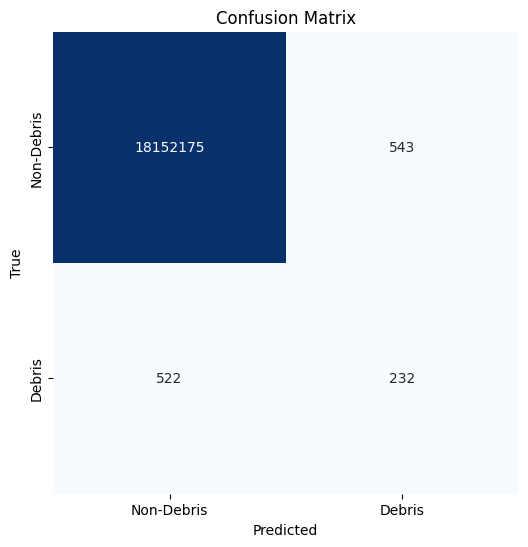

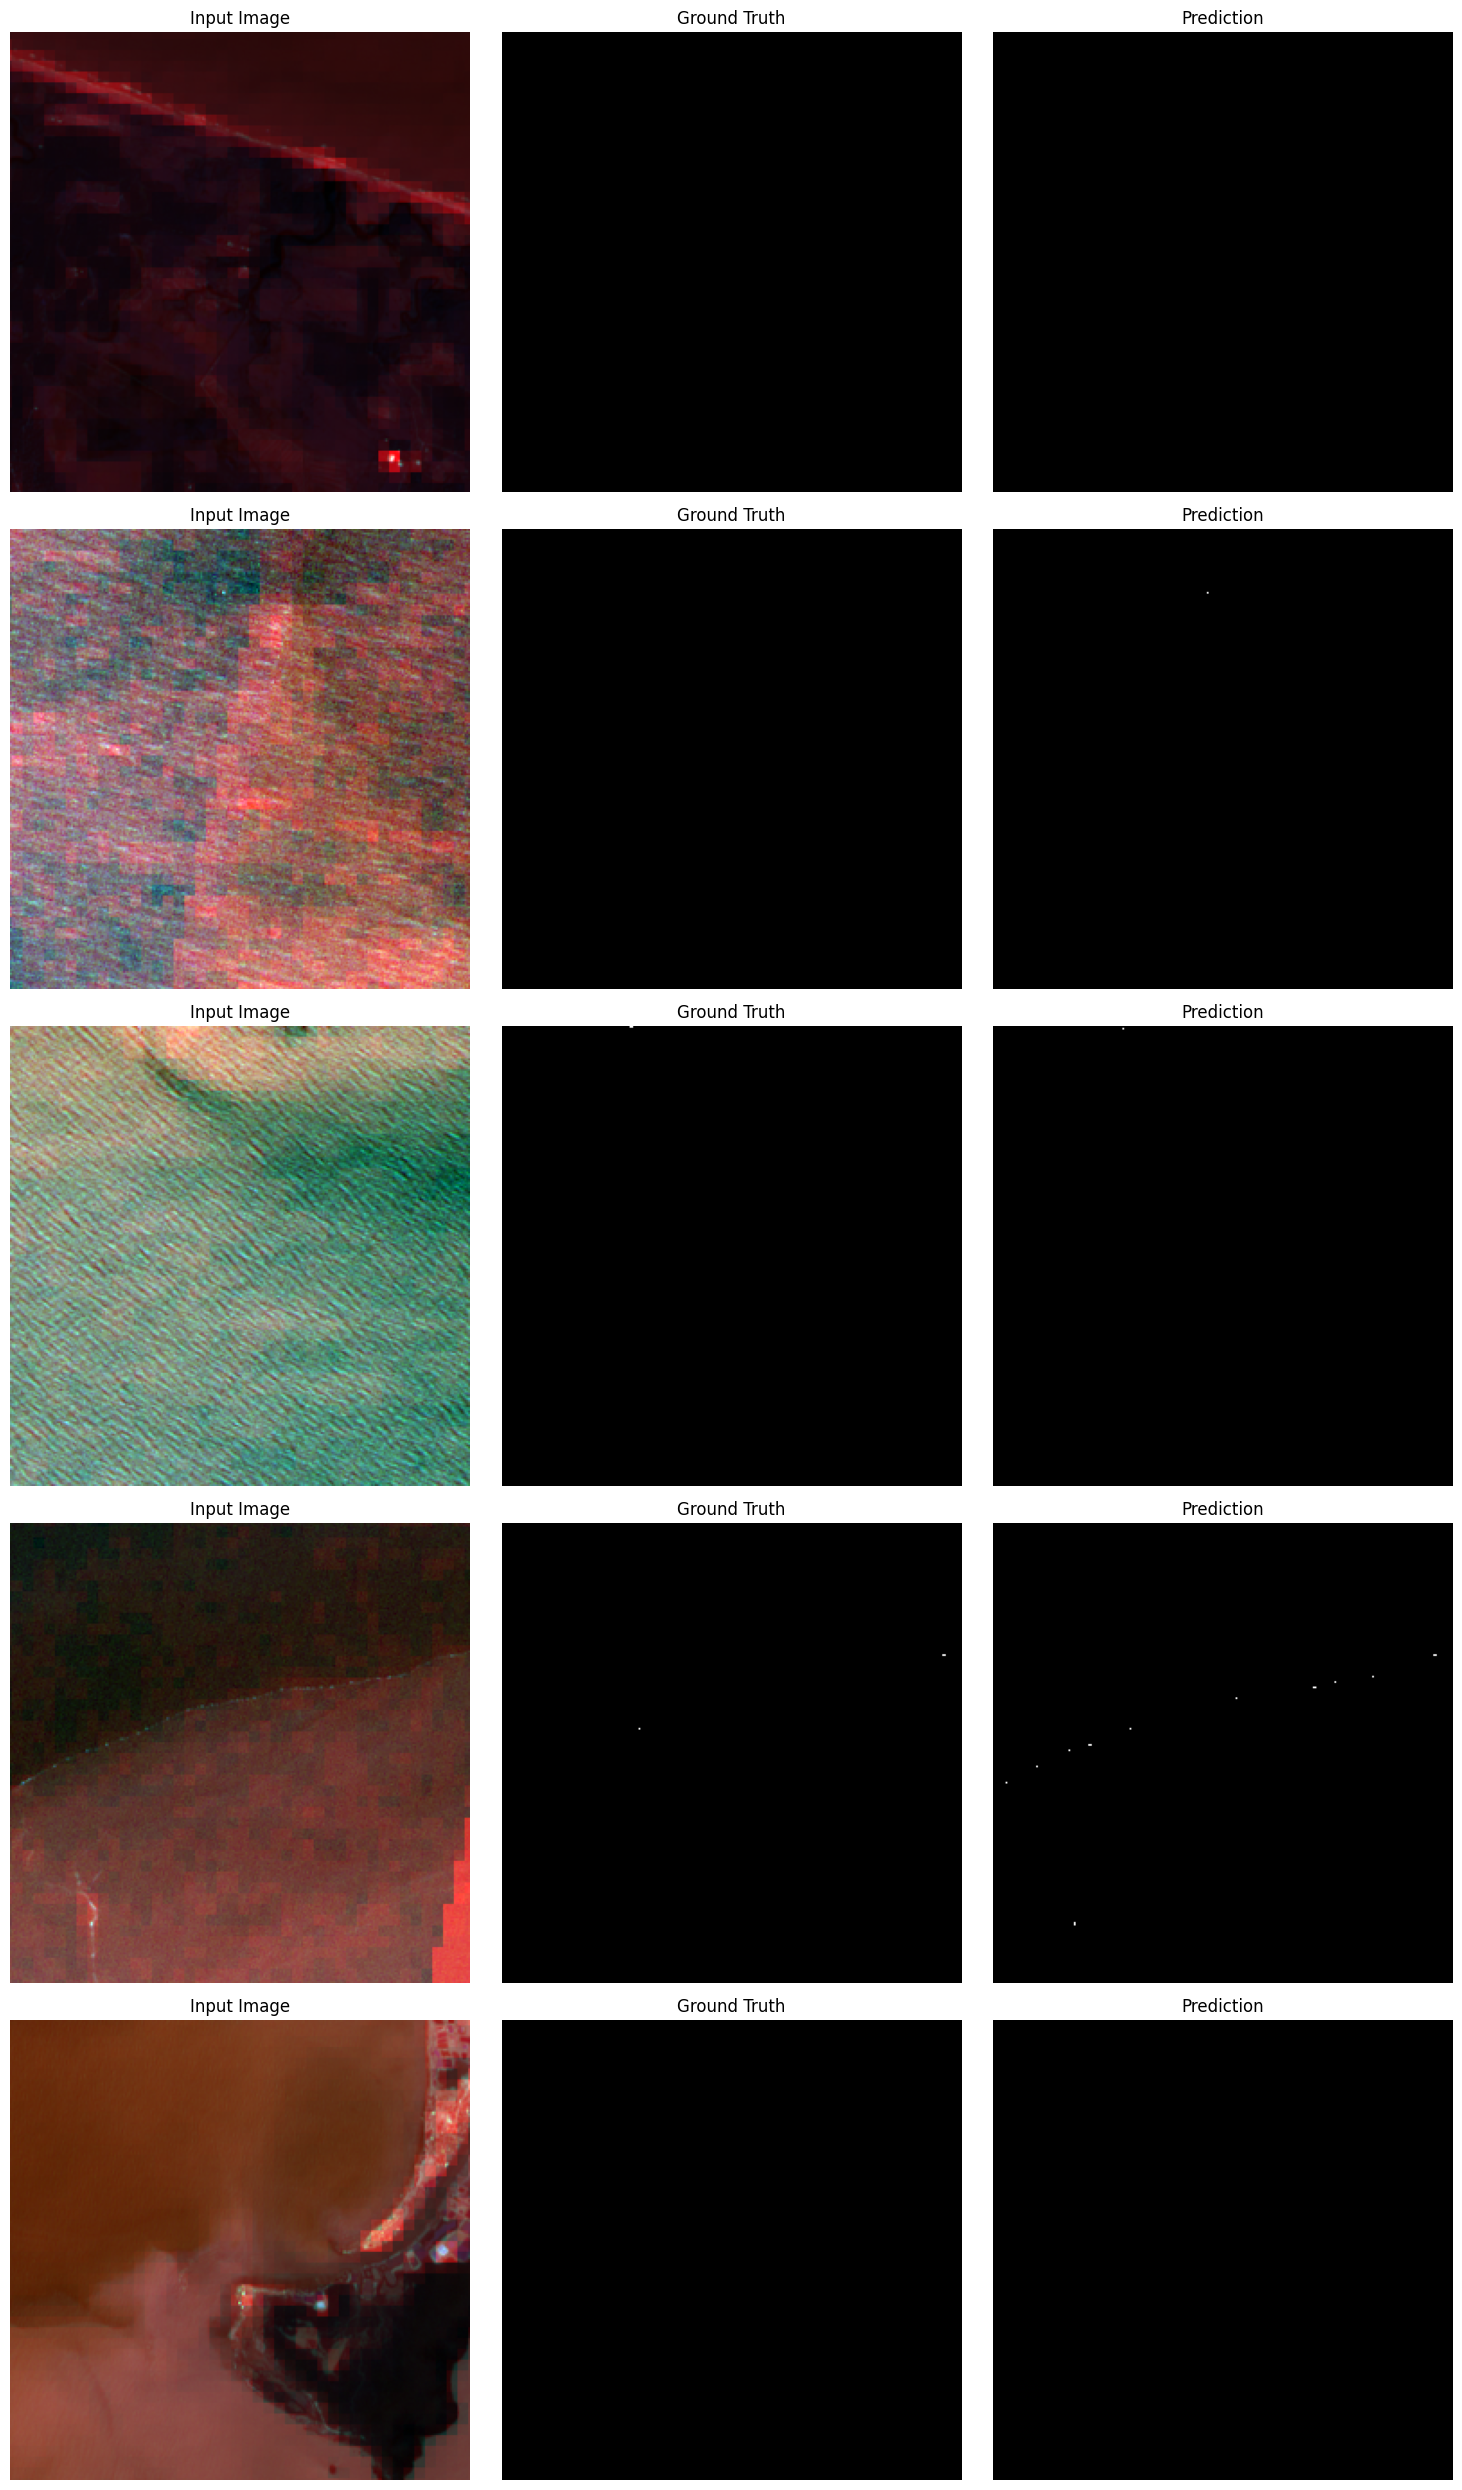

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model on test set and generate confusion matrix"""
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = (outputs > 0.5).float()  # Threshold predictions at 0.5

            # Flatten tensors for confusion matrix
            y_true.extend(targets.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Print accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Debris', 'Debris'],
                yticklabels=['Non-Debris', 'Debris'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return cm, accuracy


def visualize_predictions(model, test_loader, device='cuda', num_samples=5):
    """Visualize model predictions on test data"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i >= num_samples:
                break

            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = (outputs > 0.5).float()  # Threshold predictions at 0.5

            # Move tensors to CPU for visualization
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            preds = preds.cpu().numpy()

            # Plot input image, ground truth, and prediction
            axes[i, 0].imshow(inputs[0].transpose(1, 2, 0)[:, :, :3])  # Show RGB bands
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(targets[0].squeeze(), cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(preds[0].squeeze(), cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# Evaluate the model
cm, accuracy = evaluate_model(model, test_loader, device=device)

# Visualize predictions
visualize_predictions(model, test_loader, device=device, num_samples=5)